# LA CURVA DE LAFFER

En este notebook recojo y reproduzco los resultados de Kamal Romero [vía twitter](https://twitter.com/kamromero/status/980153464163618816), he recoplidado los tuits de ese hilo y reproducido los gráficos en Python.

Autor: Maximiliano Greco - [GitHub](https://github.com/mmngreco) - [Twitter](https://twitter.com/mmngreco)

---

[@kamromero](https://twitter.com/kamromero):

Recientemente se ha generado un debate acerca de la curva de Laffer por un artículo que afirmaba que el incremento de la recaudación del IRPF había sido consecuencia de la rebaja de tipos. 

Como excusa vamos a explicar unas cositas de la famosa curva
Acá @JL_Ferr señala todos los errores metodológicos del artículo. Suscribo todo lo que comenta, pero quiero concentrarme en otro tema, como obtener una curva de Laffer:
 
<blockquote class="twitter-tweet" data-lang="es"><p lang="es" dir="ltr">1/6<br>Otro ejemplo de cómo no hacer análisis económicos.<a href="https://t.co/k64g2GzTHe">https://t.co/k64g2GzTHe</a><br>Básicamente dice lo siguiente:<br>1. De entre todas las variables que se han movido desde que volvemos a crecer y, por ende, a recaudar más, me fijo en la que quiero (una pequeña bajada de tipos del IRPF)</p>&mdash; José Luis Ferreira (@JL_Ferr) <a href="https://twitter.com/JL_Ferr/status/978582747601137664?ref_src=twsrc%5Etfw">27 de marzo de 2018</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 


Mi motivación no es solo el mal empleo del concepto de parte de aquellos que lo usan como argumento para recomendar cualquier rebaja de impuestos, sino también aquellos que indican que dicha relación es una especie de fantasía, lo cual es igual de falso. La curva de Laffer representa una idea básica en la teoría económica, cambios en los impuestos y por ende en los precios relativos, generan cambios en el comportamiento que pueden afectar la dirección de la recaudación en la dirección opuesta a la esperada. Como he dicho al inicio, este es un hilo wonkish, voy a usar ecuaciones y conceptos básicos pero técnicos. Imaginemos un mercado de trabajo clásico en el cual existe un impuesto al salario recibido por el trabajador.

Del lado de la oferta partimos de una función Cobb-Douglas estándar, obteniendo una demanda de trabajo convencional:

### Función de Producción Cobb-Douglass


$$Y = A \cdot K^{\frac{1}{3}} \cdot N^{\frac{2}{3}}$$


### Demanda de trabajo


$$DN = \Big{(} \frac{2}{3}\frac{A}{w} \Big{)} ^{3} \cdot K$$


Del lado de la demanda, empleo una función de utilidad muy sencilla, de manera que obtenemos una oferta manejable analíticamente para la mayoría de los parámetros:

### Función de Utilidad simple


$$U = \frac{c^{\gamma}}{\gamma}- N$$


### Restricción de renta


$$C = (1- \tau_{l}) \cdot w \cdot N$$


### Oferta de trabajo


$$ON=[(1-\tau_{l}) \cdot w] ^{\big{(} \frac{\gamma}{1-\gamma} \big{)}}$$


Fíjense en la oferta de trabajo, un incremento del impuesto reduce la oferta de trabajo y la producción agregada manteniendo todo lo demás constante.

Definimos la __recaudación__ como el tipo impositivo multiplicado por las rentas salariales (salario multiplicado por el empleo):

### Recaudación


$$\tau_l \cdot W \cdot N$$


Si igualamos oferta y demanda se obtiene el nivel de empleo y salario

$$DN = ON$$

$$\Big{(} \frac{2}{3}\frac{A}{w} \Big{)} ^{3} \cdot K = [(1-\tau_{l}) \cdot w] ^{\big{(} \frac{\gamma}{1-\gamma} \big{)}}$$

Asumimos un valor de gamma igual a 0.5 para obtener una expresión sencilla del salario. Observen como al aumentar el impuesto sube el salario como consecuencia de la caída de la oferta

$$w = \Bigg{[} \Big{(}\frac{2}{3} \cdot A \Big{)}^3 \frac{K}{1 - \tau_l} \Bigg{]}^{\frac{1}{4}}$$

Con la expresión anterior puedo obtener el salario para cada nivel de impuesto y por ende el empleo, las rentas salariales y la recaudación. 

Esto se puede hacer con cualquier lenguaje numérico, lo he hecho en R (para obtener gráficos decentes). Prometo subir el código a Github

# Funciones usadas para los cálculos

In [1]:
from scipy.optimize import brentq as root
import numpy as np
import pandas as pd

def oferta_trabajo(w, tau_l, gamma=0.5):
    """Oferta de trabajo.
    
    Parameters
    ----------
    w : flaot
        Nivel de salario.
    tau_l : float
        Tipo impositivo.
    gamma : float
        Parametro de la función de utilidad.
    
    Returns
    -------
    N : float
        Oferta de trabajo.
    """
    return ((1-tau_l) * w) ** (gamma / (1-gamma))

def demanda_trabajo(w, alfa=2/3, A=1, K=400):
    """Demanda de trabajo.
    
    Parameters
    ----------
    alfa : float
        Parámetro de la función de producción asociado al 
        empleo.
    A : int
        Avance tecnológico (PTF).
    K : int
        Stock de Capital.
    
    Returns
    -------
    N : float
        Demanda de trabajo.
    """
    return ((alfa * (A/w)) ** (1/(1-alfa))) * K

def produccion(alfa=2/3, A=1, K=400):
    """Nivel de producción.
    
    Calcula el nivel de producción según una función 
    de producción Cobb-Douglas.
    
    Parameters
    ----------
    alfa : float
        Potencia asociada al nivel de empleo.
    A : int or float
        Avance tecnológico (PTF)
    K : int or float
        Stock de capital.
    
    Returns
    -------
    Y : float
        Nivel de producción.
    """
    return A * (K ** (1-alfa)) * (N ** alfa)

def empleo(w,  alfa=2/3, A=1, K=400):
    """Nivel de empleo.
    
    Parameters
    ----------
    w : flaot
        Nivel de salario.
    alfa : float
        Potencia asociada al nivel de empleo.
    A : int or float
        Avance tecnológico (PTF)
    K : int or float
        Stock de capital.
    
    
    Returns
    -------
    N : float
        Nivel de empleo en el equilibrio.
    """
    return ((alfa * (A/w)) ** (1/(1-alfa)))* K

def recaudacion(tau_l, w, N):
    """Recaudación impositiva.
    
    Paremeters
    ----------
    tau_l : float
        Tipo impositivo.
    w : float
        Salario.
    N : int or float
        Empleo.
    
    Returns
    -------
    R : float
        Recaudación impositiva.
    """
    return tau_l * w * N

def exceso_dda(w, tau_l, alfa=2/3, gamma=0.5, A=1, K=400):
    """Calcula el exceso de demanda de trabajo.

    Parameters
    ----------
    w : flaot
        Nivel de salario.
    tau_l : float
        Tipo impositivo.
    gamma : float
        Parametro de la función de utilidad.
    A : int or float
        Avance tecnológico (PTF)
    K : int or float
        Stock de capital.
    
    Returns
    -------
    N : float
        Exceso de demanda de trabajo.

    """
    DN = demanda_trabajo(w=w, alfa=alfa, A=A, K=K)
    ON = oferta_trabajo(w=w, tau_l=tau_l, gamma=gamma)
    return DN - ON

def w_equilibrio(function=exceso_dda, lower=0.1**6, upper=20, *args):
    """Salario de equilibrio.
    
    Parameters
    ----------
    function : function
    lower : int or float
        Límite inferior de la primera variable en `function`.
    upper : int or float
        Límite superior de la primera varible en `function`.
    args : tuple
        Otros argumentos que se le pasarán a `function`.
    
    Returns
    -------
    w_equilibrio : float
        Salario que vacía el mercado.
    """
    return root(function, lower, upper, args=args)

def parametros():
    """Define parámetros por defecto.
    
    Returns
    -------
    parameters : dict
        alfa, K, A, gamma
    """
    return dict(alfa=2/3, K=400, A=1, gamma=0.5)

In [2]:
tipo_impositivo = np.arange(0,100, 1) / 100
cols = "tipo_impositivo recaudacion empleo produccion salario".split()

# Espacio reservado
results = np.empty((len(tipo_impositivo), len(cols)))

# Añade las variables
globals().update(parametros())  

# Bucle que calcula variables de equilibrio
for i, tipo in enumerate(tipo_impositivo):
    w = w_equilibrio(exceso_dda, 0.0001, 20, tipo)
    N = empleo(w)
    R = recaudacion(tipo, w, N)
    Y = produccion()
    results[i,:] = [tipo, R, N, Y, w]

# Gráficos

In [3]:
# Librerías y funciones auxiliares
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

def set_style():
    plt.style.use("ggplot")
    # plt.style.use(['seaborn-paper'])
    matplotlib.rc("font", family="Times New Roman", size=15)
    plt.rcParams['xtick.labelsize'] = 11
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.serif'] = 'cm'


def set_size(fig, w, h):
    fig.set_size_inches(w, h)
    plt.tight_layout()

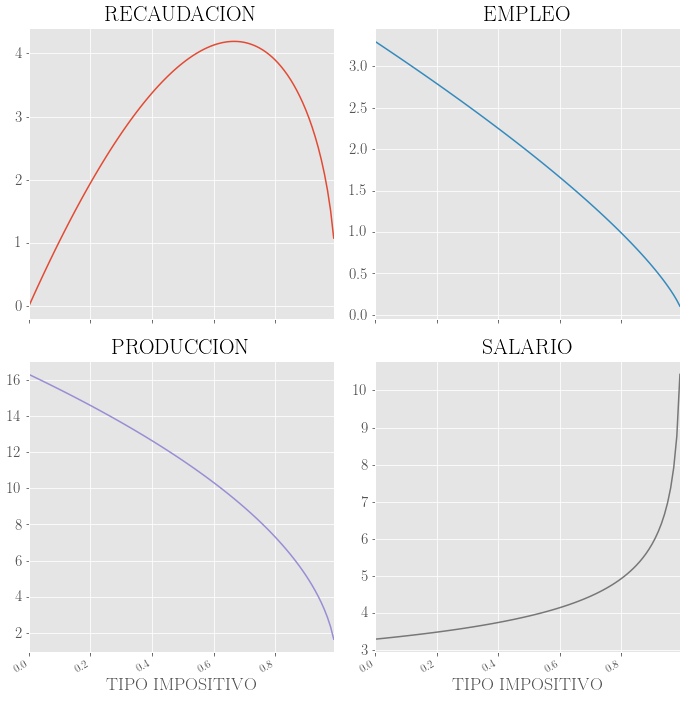

In [4]:
# Grafico
set_style()

data = pd.DataFrame(results, columns=cols).set_index('tipo_impositivo')
axs = data.plot(subplots=True, layout=(2,2), legend=False, sharex=True)

# Algunos cambios de estilo
for i, ax in enumerate(axs.flatten()):
    ax.grid(True)
    ax.set_title(data.columns[i].upper().replace("_", " "))
    ax.set_xlabel(ax.get_xlabel().replace("_", " ").upper())

fig = plt.gcf()
set_size(fig, 10, 10)

Observen como obtenemos una relación no monótona entre recaudación y tipo impositivo (curva de Laffer).

Asimismo podemos ver que fuerzas operan:

1. sube del tipo impositivo
1. disminuye el empleo
1. sube el salario

A partir de análisis similares pero más complejos (introducir dinámica, más impuestos, funciones de utilidad más complejas, etc.) se pueden obtener resultados muy similares a nivel cualitativo.

## Resumiendo

Las curvas de Laffer existen teóricamente y son útiles, pero empíricamente (parametrizando ejercicios más complejos con datos de economías reales) se ha demostrado que muy pocos países (concentrados en el norte de Europa) tienen capacidad de incrementar la recaudación disminuyendo los tipos:

![](https://pbs.twimg.com/media/DZoy9tEW0AAQ6uV.jpg)

Que algunos opinadores sin formalidad alguna decidan emplear la relación de Laffer como excusa para bajar tipos para incrementar la recaudación bajo cualquier circunstancia, no implica que el concepto como tal no sea válido.

